In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML


/var/folders/ny/9v084qqs5bv3c8gmyggl1ypc0000gn/T/ipykernel_42116/1202922517.py:24: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

(128, 128, 3)


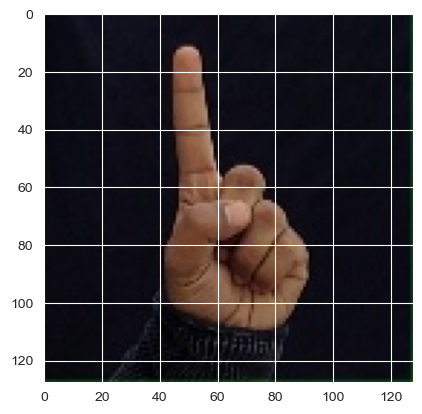

In [3]:
fpath=r'Data/1/0.jpg'
img=plt.imread(fpath)
print (img.shape)
imshow(img)

In [4]:
sdir=r'Data'
filepaths=[]
labels=[]
classlist=os.listdir(sdir) 
for klass in classlist:
    classpath=os.path.join(sdir, klass)
    flist=os.listdir(classpath)
    for f in flist:
        fpath=os.path.join(classpath,f)        
        filepaths.append(fpath)
        labels.append(klass)
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels') 
    df=pd.concat([Fseries, Lseries], axis=1)    
        
print('df length: ', len(df) )
balance=df['labels'].value_counts()
print (balance)

df length:  42745
C    1447
O    1429
I    1379
V    1290
R    1200
E    1200
Q    1200
4    1200
X    1200
3    1200
B    1200
K    1200
L    1200
2    1200
Y    1200
5    1200
P    1200
D    1200
M    1200
J    1200
U    1200
H    1200
F    1200
A    1200
S    1200
T    1200
8    1200
1    1200
Z    1200
6    1200
G    1200
N    1200
7    1200
9    1200
W    1200
Name: labels, dtype: int64


In [5]:
train_split=.9
valid_split=.05
dummy_split=valid_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  38470   test_df length:  2138   valid_df length:  2137


In [6]:
height=128
width=128
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    #img=img/127.5-1
    return img 
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  2   test steps:  1069
Found 38470 validated image filenames belonging to 35 classes.
Found 2138 validated image filenames belonging to 35 classes.
Found 2137 validated image filenames belonging to 35 classes.


In [7]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

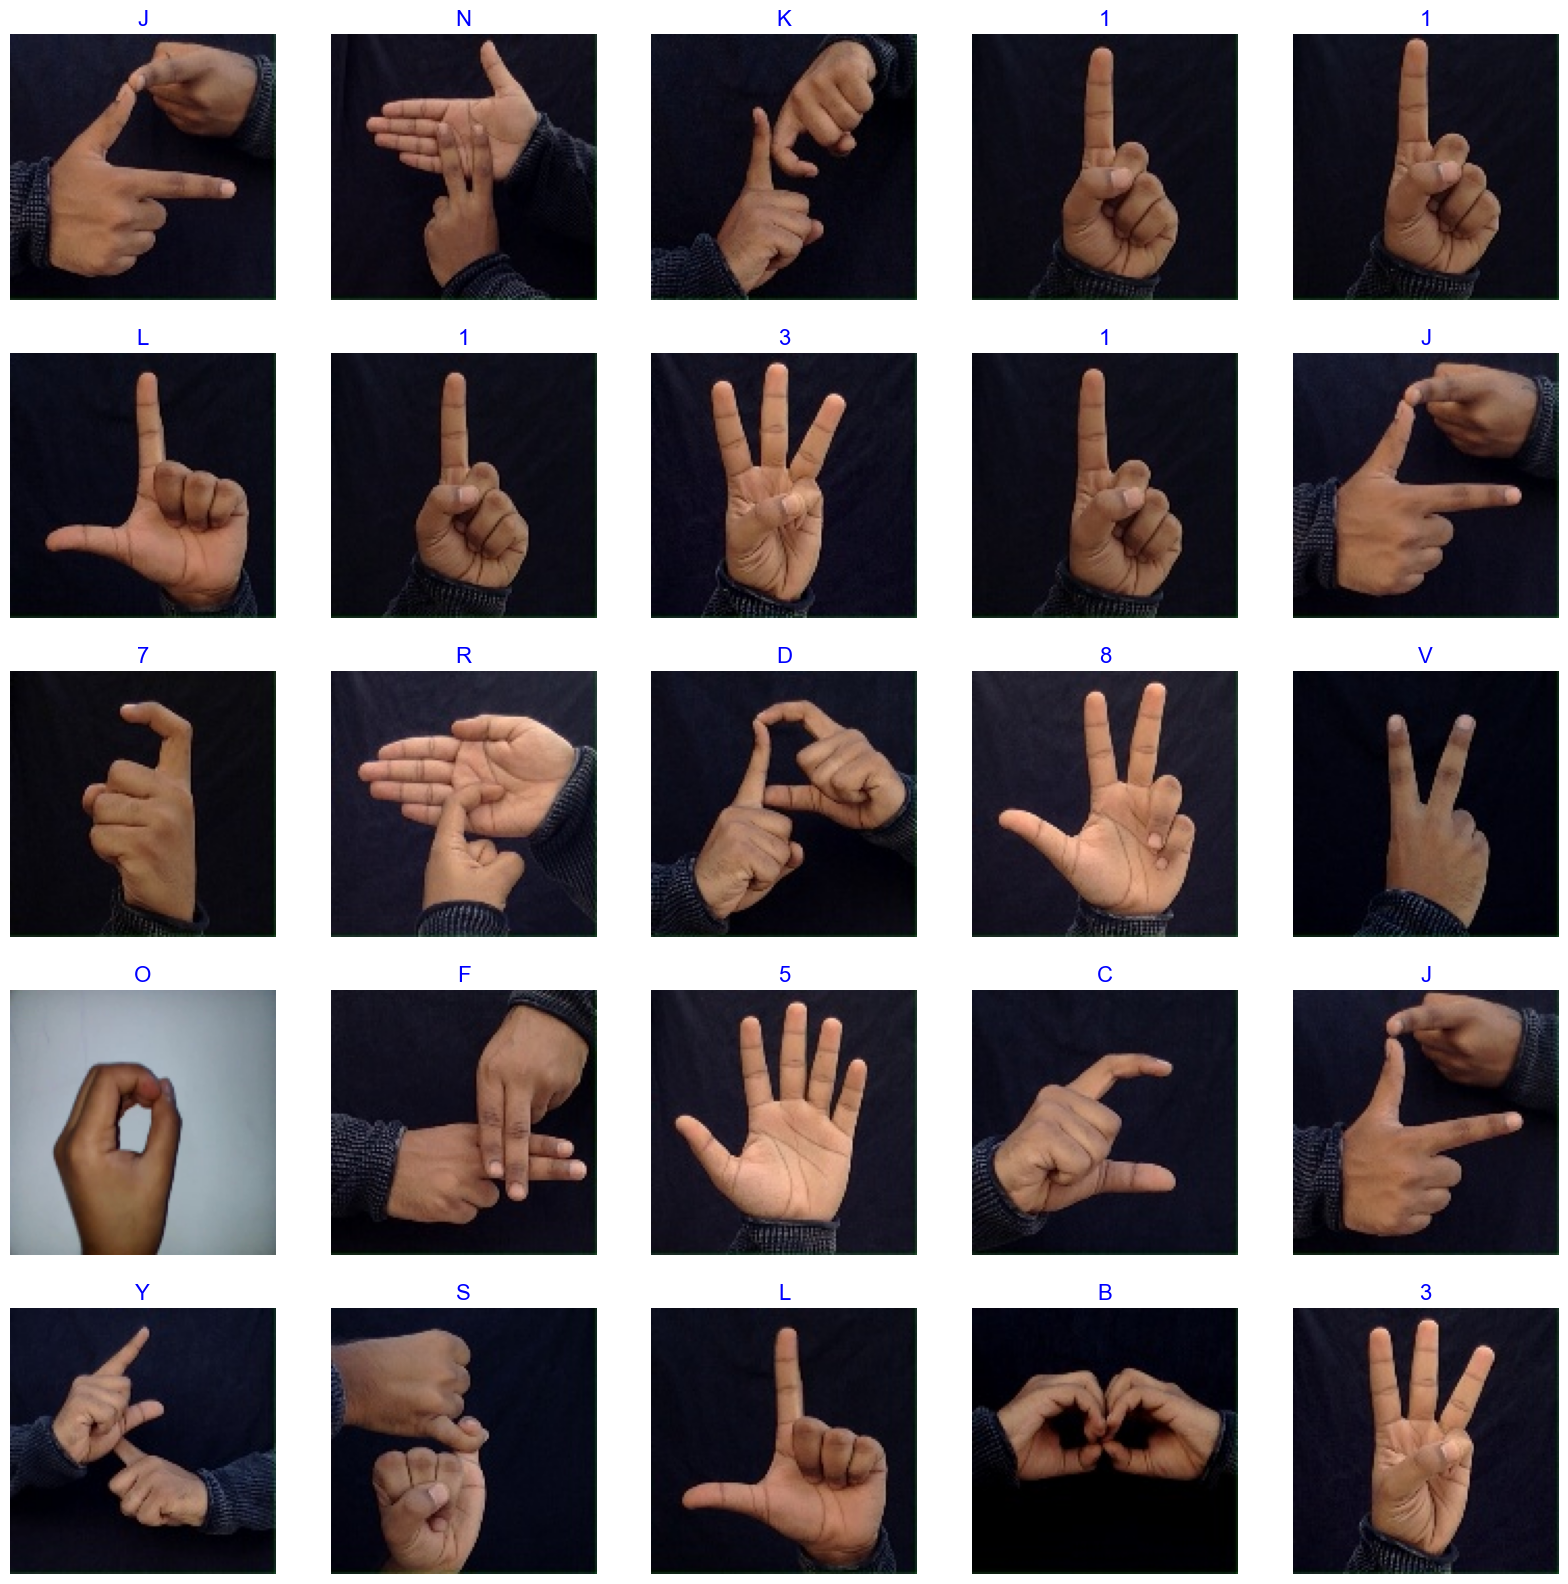

In [31]:
show_image_samples(valid_gen)


In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2B3

pretrained_model = EfficientNetV2B3(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
)

for layer in pretrained_model.layers:
    layer.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = Dropout(0.4)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(35, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('model/model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    epochs=10,
                    callbacks=callbacks)


Epoch 1/10
962/962 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.9457
Epoch 1: val_loss improved from inf to 0.00393, saving model to model/model.h5
962/962 [==============================] - 274s 270ms/step - loss: 0.3193 - accuracy: 0.9457 - val_loss: 0.0039 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/10
962/962 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9996
Epoch 2: val_loss improved from 0.00393 to 0.00100, saving model to model/model.h5
962/962 [==============================] - 234s 243ms/step - loss: 0.0061 - accuracy: 0.9996 - val_loss: 0.0010 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/10
962/962 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9998
Epoch 3: val_loss improved from 0.00100 to 0.00053, saving model to model/model.h5
962/962 [==============================] - 234s 243ms/step - loss: 0.0026 - accuracy: 0.9998 - val_loss: 5.2936e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4

KeyboardInterrupt: 

In [16]:
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 128, 128, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 128, 128, 3)  0          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

                                                                 ']                               
                                                                                                  
 block2c_project_bn (BatchNorma  (None, 32, 32, 40)  160         ['block2c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2c_drop (Dropout)         (None, 32, 32, 40)   0           ['block2c_project_bn[0][0]']     
                                                                                                  
 block2c_add (Add)              (None, 32, 32, 40)   0           ['block2c_drop[0][0]',           
                                                                  'block2b_add[0][0]']            
                                                                                                  
 block3a_e

                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 14)     3150        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 224)    3360        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 8, 8, 224)    0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_project_conv (Conv2D)  (None, 8, 8, 112)    25088       ['block4a_se_excite[0][0]']      
                                                                                                  
 block4a_p

 block4c_project_bn (BatchNorma  (None, 8, 8, 112)   448         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 8, 8, 112)    0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 8, 8, 112)    0           ['block4c_drop[0][0]',           
                                                                  'block4b_add[0][0]']            
                                                                                                  
 block4d_expand_conv (Conv2D)   (None, 8, 8, 448)    50176       ['block4c_add[0][0]']            
                                                                                                  
 block4d_e

 block4e_add (Add)              (None, 8, 8, 112)    0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 8, 8, 672)    75264       ['block4e_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 8, 8, 672)   2688        ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 8, 8, 672)   0           ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block5c_dwconv2 (DepthwiseConv  (None, 8, 8, 816)   7344        ['block5c_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 8, 8, 816)   3264        ['block5c_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5c_activation (Activation  (None, 8, 8, 816)   0           ['block5c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5c_s

 )                                                                                                
                                                                                                  
 block5e_activation (Activation  (None, 8, 8, 816)   0           ['block5e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 816)         0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_se_reshape (Reshape)   (None, 1, 1, 816)    0           ['block5e_se_squeeze[0][0]']     
                                                                                                  
 block5e_s

 block5g_se_squeeze (GlobalAver  (None, 816)         0           ['block5g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5g_se_reshape (Reshape)   (None, 1, 1, 816)    0           ['block5g_se_squeeze[0][0]']     
                                                                                                  
 block5g_se_reduce (Conv2D)     (None, 1, 1, 34)     27778       ['block5g_se_reshape[0][0]']     
                                                                                                  
 block5g_se_expand (Conv2D)     (None, 1, 1, 816)    28560       ['block5g_se_reduce[0][0]']      
                                                                                                  
 block5g_se_excite (Multiply)   (None, 8, 8, 816)    0           ['block5g_activation[0][0]',     
          

                                                                  'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, 4, 4, 232)    322944      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_project_bn (BatchNorma  (None, 4, 4, 232)   928         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 4, 4, 232)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 4, 4, 232)    0           ['block6b_drop[0][0]',           
          

 lization)                                                                                        
                                                                                                  
 block6d_drop (Dropout)         (None, 4, 4, 232)    0           ['block6d_project_bn[0][0]']     
                                                                                                  
 block6d_add (Add)              (None, 4, 4, 232)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block6e_expand_conv (Conv2D)   (None, 4, 4, 1392)   322944      ['block6d_add[0][0]']            
                                                                                                  
 block6e_expand_bn (BatchNormal  (None, 4, 4, 1392)  5568        ['block6e_expand_conv[0][0]']    
 ization) 

                                                                  'block6e_add[0][0]']            
                                                                                                  
 block6g_expand_conv (Conv2D)   (None, 4, 4, 1392)   322944      ['block6f_add[0][0]']            
                                                                                                  
 block6g_expand_bn (BatchNormal  (None, 4, 4, 1392)  5568        ['block6g_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6g_expand_activation (Act  (None, 4, 4, 1392)  0           ['block6g_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6g_d

 ization)                                                                                         
                                                                                                  
 block6i_expand_activation (Act  (None, 4, 4, 1392)  0           ['block6i_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6i_dwconv2 (DepthwiseConv  (None, 4, 4, 1392)  12528       ['block6i_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6i_bn (BatchNormalization  (None, 4, 4, 1392)  5568        ['block6i_dwconv2[0][0]']        
 )                                                                                                
          

 block6k_dwconv2 (DepthwiseConv  (None, 4, 4, 1392)  12528       ['block6k_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6k_bn (BatchNormalization  (None, 4, 4, 1392)  5568        ['block6k_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6k_activation (Activation  (None, 4, 4, 1392)  0           ['block6k_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6k_se_squeeze (GlobalAver  (None, 1392)        0           ['block6k_activation[0][0]']     
 agePoolin

                                                                                                  
 dense_7 (Dense)                (None, 1024)         1049600     ['dropout_4[0][0]']              
                                                                                                  
 dropout_5 (Dropout)            (None, 1024)         0           ['dense_7[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 35)           35875       ['dropout_5[0][0]']              
                                                                                                  
Total params: 15,589,985
Trainable params: 2,659,363
Non-trainable params: 12,930,622
__________________________________________________________________________________________________


In [35]:
import cv2
import numpy as np
from keras.models import load_model

# Load the pre-trained Keras model
model = load_model('model/model.h5')

# Create a dictionary to map prediction indices to labels (if needed)
labels={0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: 'A', 10: 'B', 11: 'C', 12: 'D', 13: 'E', 14: 'F', 15: 'G', 16: 'H', 17: 'I', 18: 'J', 19: 'K', 20: 'L', 21: 'M', 22: 'N', 23: 'O', 24: 'P', 25: 'Q', 26: 'R', 27: 'S', 28: 'T', 29: 'U', 30: 'V', 31: 'W', 32: 'X', 33: 'Y', 34: 'Z'}


def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Preprocess the image (resize, normalize, etc.) to match the model input size and format
    preprocessed_image = cv2.resize(image, (224, 224))  # Adjust the size according to your model's input
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension

    return preprocessed_image

def get_prediction(image_path):
    # Preprocess the input image
    preprocessed_image = preprocess_image(image_path)

    # Make prediction using the model
    prediction = model.predict(preprocessed_image)

    # Interpret the prediction result and obtain the label
    predicted_class_index = np.argmax(prediction)
    predicted_label = labels.get(predicted_class_index, f'Class {predicted_class_index}')

    return predicted_label
    

# Provide the path to your image here
image_path = '3.jpg'
predicted_label = get_prediction(image_path)
print("Predicted Label:", predicted_label)


1/1 [==============================] - 6s 6s/step
Predicted Label: 5
